This notebook computes brain states for the awake condition

In [1]:
import sys
sys.path
sys.path.append('/neurospin/lbi/monkeyfmri/deepstim/workspace/2023_ASM_tembedding/gitproject/2023_asm_tembedding/code')

In [19]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import matplotlib.cm as cm
import torch
import torch.nn as nn
import cebra_v2 as cebra2
from collections import defaultdict
import torch.nn.functional as F
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA,FastICA
from torch.utils.data.sampler import BatchSampler
import package
import pandas as pd
import scipy as sc
from skimage.metrics import structural_similarity as ssim
from sklearn.cluster import KMeans,OPTICS,DBSCAN
import math
import time
import os
from scipy.spatial.transform import Rotation as R
import sklearn

In [217]:
import importlib
importlib.reload(package.preprocessing)
importlib.reload(cebra2.distribution)
importlib.reload(cebra2.dataset)

<module 'cebra_v2.dataset' from '/volatile/aurelien_stumpf_mascles/project/code/cebra_v2/dataset.py'>

## Présentation

Dans ce notebook, on essaye d'identifier les brain states de la condition awake grâce à la méthode CEBRA.

## Fonctions utiles

In [27]:
def display(states,li_titles):
    fig = plt.figure(figsize=(11, 11))
    
    # setting values to rows and column variables
    n = len(states)
    rows = int(np.sqrt(n))+1
    columns = n // (rows-1)
    
    for i in range(n):
        fig.add_subplot(rows, columns, i+1)
        # showing image
        plt.imshow(states[i],cmap="hot")
        plt.axis('off')
        plt.title(li_titles[i])

In [5]:
cd /neurospin/lbi/monkeyfmri/deepstim/database/ANESTHETIC_database/derivatives/reference_kmeans/inputs

/neurospin/lbi/monkeyfmri/deepstim/database/ANESTHETIC_database/derivatives/reference_kmeans/inputs


In [6]:
ls

input_flat.npy*  labels.tsv*  metadata.tsv*     structural.txt*
inputs.npy*      labels.txt*  regionalmap.pdf*


## Data Loading

Dans le train, on garde les singes 'almira', 'khali', 'kimiko', 'rana'.
Dans le test, on utilise 'jade'.

In [61]:
mine = 2

if mine == 1: 
    timeseries = np.load("/neurospin/lbi/monkeyfmri/deepstim/workspace/2023_ASM_tembedding/gitproject/2023_asm_tembedding/data/DFCs/0.03-0.11-addcompor-False/timeseries_04-08.npy")
    meta = pd.read_csv("/neurospin/lbi/monkeyfmri/deepstim/workspace/2023_ASM_tembedding/gitproject/2023_asm_tembedding/data/DFCs/0.03-0.11-addcompor-False/meta_04-08.csv", sep=",")
    dfc = np.load("/neurospin/lbi/monkeyfmri/deepstim/workspace/2023_ASM_tembedding/gitproject/2023_asm_tembedding/data/DFCs/0.03-0.11-addcompor-False/inputs_04-08.npy")
    id_sessions_awake_train = np.array([i for i in range(len(meta)) if meta["condition"].iloc[i] in ["awake"] and meta["monkey"].iloc[i] in ['almira', 'khali', 'kimiko', 'rana']])
    id_sessions_awake_test = np.array([i for i in range(len(meta)) if meta["condition"].iloc[i] in ["awake"] and meta["monkey"].iloc[i] in ['jade']])
    id_sessions_light_propofol_train = np.array([i for i in range(len(meta)) if meta["condition"].iloc[i] in ["light-propofol"] and meta["monkey"].iloc[i] in ['almira', 'khali', 'kimiko', 'rana']])
    id_sessions_light_propofol_test = np.array([i for i in range(len(meta)) if meta["condition"].iloc[i] in ["light-propofol"] and meta["monkey"].iloc[i] in ['jade']])
    id_sessions_deep_propofol_train = np.array([i for i in range(len(meta)) if meta["condition"].iloc[i] in ["deep-propofol"] and meta["monkey"].iloc[i] in ['almira', 'khali', 'kimiko', 'rana']])
    id_sessions_deep_propofol_test = np.array([i for i in range(len(meta)) if meta["condition"].iloc[i] in ["deep-propofol"] and meta["monkey"].iloc[i] in ['jade']])
    id_sessions_ketamine_train = np.array([i for i in range(len(meta)) if meta["condition"].iloc[i] in ["ketamine"] and meta["monkey"].iloc[i] in ['almira', 'khali', 'kimiko', 'rana']])
    id_sessions_ketamine_test = np.array([i for i in range(len(meta)) if meta["condition"].iloc[i] in ["ketamine"] and meta["monkey"].iloc[i] in ['jade']])
    id_sessions_sevoflurane2_train = np.array([i for i in range(len(meta)) if meta["condition"].iloc[i] in ["sevoflurane2"] and meta["monkey"].iloc[i] in ['almira', 'khali', 'kimiko', 'rana']])
    id_sessions_sevoflurane2_test = np.array([i for i in range(len(meta)) if meta["condition"].iloc[i] in ["sevoflurane2"] and meta["monkey"].iloc[i] in ['jade']])
    id_sessions_sevoflurane4_train = np.array([i for i in range(len(meta)) if meta["condition"].iloc[i] in ["sevoflurane4"] and meta["monkey"].iloc[i] in ['almira', 'khali', 'kimiko', 'rana'] ])
    id_sessions_sevoflurane4_test = np.array([i for i in range(len(meta)) if meta["condition"].iloc[i] in ["sevoflurane4"] and meta["monkey"].iloc[i] in ['jade']])
elif mine == 2: 
    timeseries = np.load("/neurospin/lbi/monkeyfmri/deepstim/workspace/2023_ASM_tembedding/gitproject/2023_asm_tembedding/data/DFCs/0.01-0.1_addcompor-False/timeseries_01-1.npy")
    meta = pd.read_csv("/neurospin/lbi/monkeyfmri/deepstim/workspace/2023_ASM_tembedding/gitproject/2023_asm_tembedding/data/DFCs/0.01-0.1_addcompor-False/meta_01-1.csv", sep=",")
    dfc = np.load("/neurospin/lbi/monkeyfmri/deepstim/workspace/2023_ASM_tembedding/gitproject/2023_asm_tembedding/data/DFCs/0.01-0.1_addcompor-False/inputs_01-1.npy")
    id_sessions_awake_train = np.array([i for i in range(len(meta)) if meta["condition"].iloc[i] in ["awake"] and meta["monkey"].iloc[i] in ['almira', 'khali', 'kimiko', 'rana']])
    id_sessions_awake_test = np.array([i for i in range(len(meta)) if meta["condition"].iloc[i] in ["awake"] and meta["monkey"].iloc[i] in ['jade']])
    id_sessions_light_propofol_train = np.array([i for i in range(len(meta)) if meta["condition"].iloc[i] in ["light-propofol"] and meta["monkey"].iloc[i] in ['almira', 'khali', 'kimiko', 'rana']])
    id_sessions_light_propofol_test = np.array([i for i in range(len(meta)) if meta["condition"].iloc[i] in ["light-propofol"] and meta["monkey"].iloc[i] in ['jade']])
    id_sessions_deep_propofol_train = np.array([i for i in range(len(meta)) if meta["condition"].iloc[i] in ["deep-propofol"] and meta["monkey"].iloc[i] in ['almira', 'khali', 'kimiko', 'rana']])
    id_sessions_deep_propofol_test = np.array([i for i in range(len(meta)) if meta["condition"].iloc[i] in ["deep-propofol"] and meta["monkey"].iloc[i] in ['jade']])
    id_sessions_ketamine_train = np.array([i for i in range(len(meta)) if meta["condition"].iloc[i] in ["ketamine"] and meta["monkey"].iloc[i] in ['almira', 'khali', 'kimiko', 'rana']])
    id_sessions_ketamine_test = np.array([i for i in range(len(meta)) if meta["condition"].iloc[i] in ["ketamine"] and meta["monkey"].iloc[i] in ['jade']])
    id_sessions_sevoflurane2_train = np.array([i for i in range(len(meta)) if meta["condition"].iloc[i] in ["sevoflurane2"] and meta["monkey"].iloc[i] in ['almira', 'khali', 'kimiko', 'rana']])
    id_sessions_sevoflurane2_test = np.array([i for i in range(len(meta)) if meta["condition"].iloc[i] in ["sevoflurane2"] and meta["monkey"].iloc[i] in ['jade']])
    id_sessions_sevoflurane4_train = np.array([i for i in range(len(meta)) if meta["condition"].iloc[i] in ["sevoflurane4"] and meta["monkey"].iloc[i] in ['almira', 'khali', 'kimiko', 'rana'] ])
    id_sessions_sevoflurane4_test = np.array([i for i in range(len(meta)) if meta["condition"].iloc[i] in ["sevoflurane4"] and meta["monkey"].iloc[i] in ['jade']])
else :
    ## FOR ORIGINAL DATA
    timeseries = np.load("/neurospin/lbi/monkeyfmri/deepstim/database/ANESTHETIC_database/derivatives/nsm_timeseries/cocomac/timeseries.npy")
    meta = pd.read_csv("/neurospin/lbi/monkeyfmri/deepstim/database/ANESTHETIC_database/derivatives/reference_kmeans/inputs/metadata.tsv", sep="\t")
    dfc = np.load('/neurospin/lbi/monkeyfmri/deepstim/database/DBS_database/rawdata/dfc/outliers/dfc.npy')
    n_runs = len(meta)
    n_wins = 461
    dfc_train = dfc[meta["monkey"].isin(['almira', 'khali', 'kimiko', 'rana'])].reshape((-1, n_wins, 82, 82))
    dfc_test = dfc[(meta["monkey"] == "jade")].reshape((-1, n_wins, 82, 82))
    dfc_all = dfc.reshape((-1, n_wins, 82, 82))
    id_sessions_awake = np.array([i for i in range(len(meta)//464) if meta["condition"].iloc[i*464] in ["awake"]])
    id_sessions_light_propofol = np.array([i for i in range(len(meta)//464) if meta["condition"].iloc[i*464] in ["light-propofol"] and meta["monkey"].iloc[i*464]])
    id_sessions_deep_propofol = np.array([i for i in range(len(meta)//464) if meta["condition"].iloc[i*464] in ["deep-propofol"] and meta["monkey"].iloc[i*464]])
    id_sessions_ketamine = np.array([i for i in range(len(meta)//464) if meta["condition"].iloc[i*464] in ["ketamine"]])
    id_sessions_light_sevoflurane = np.array([i for i in range(len(meta)//464) if meta["condition"].iloc[i*464] in ["light-sevoflurane"] and meta["monkey"].iloc[i*464]])
    id_sessions_deep_sevoflurane = np.array([i for i in range(len(meta)//464) if meta["condition"].iloc[i*464] in ["deep-sevoflurane"] and meta["monkey"].iloc[i*464]])

In [83]:
meta[4:21]

Unnamed: 0 monkey       ses  run condition
4            4   jade  20120824   10     awake
5            5   jade  20120824    6     awake
6            6   jade  20120824    7     awake
7            7   jade  20120824    8     awake
8            8   jade  20120824    9     awake
9            9   jade  20120907   10     awake
10          10   jade  20120907   11     awake
11          11   jade  20120907   12     awake
12          12   jade  20120907    6     awake
13          13   jade  20120907    7     awake
14          14   jade  20120907    8     awake
15          15   jade  20120907    9     awake
16          16   jade  20120928   20     awake
17          17   jade  20121026   30     awake
18          18   jade  20121109   28     awake
19          19   jade  20121116   27     awake
20          20   jade  20121214   26     awake

In [84]:
id_sessions = np.array([i for i in range(len(meta)) if meta["condition"].iloc[i] in ["ketamine"]])

In [87]:
id_sessions = np.array([i for i in range(len(meta)) if meta["condition"].iloc[i] in ["awake"]])
print("awake :",id_sessions)
id_sessions = np.array([i for i in range(len(meta)) if meta["condition"].iloc[i] in ["light-propofol"]])
print("light-propofol :",id_sessions)
id_sessions = np.array([i for i in range(len(meta)) if meta["condition"].iloc[i] in ["deep-propofol"]])
print("deep-propofol :",id_sessions)
id_sessions = np.array([i for i in range(len(meta)) if meta["condition"].iloc[i] in ["ketamine"]])
print("ketamine :",id_sessions)
id_sessions = np.array([i for i in range(len(meta)) if meta["condition"].iloc[i] in ["sevoflurane2"]])
print("sevoflurane2 :",id_sessions)
id_sessions = np.array([i for i in range(len(meta)) if meta["condition"].iloc[i] in ["sevoflurane4"]])
print("sevoflurane4 :",id_sessions)

awake : [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30]
light-propofol : [56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79
 80]
deep-propofol : [ 81  82  83  84  85  86  87  88  89  90  91  92  93  94  95  96  97  98
  99 100 101 102 103 104 105 106 107 108 109 110]
ketamine : [31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54
 55]
sevoflurane2 : [111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127 128
 129 130 131 132 133]
sevoflurane4 : [134 135 136 137 138 139 140 141 142 143 144 145 146 147 148 149 150 151
 152 153]


## Best Matrix

In [103]:
id_sessions_awake = np.array([i for i in range(len(meta)) if meta["condition"].iloc[i] in ["awake"]])
dfc_awake = dfc[id_sessions_awake,:,:,:].reshape(-1,82,82)
mat = torch.from_numpy(dfc_awake).flatten(1)
accu = torch.var(mat,dim = -1).detach().numpy()

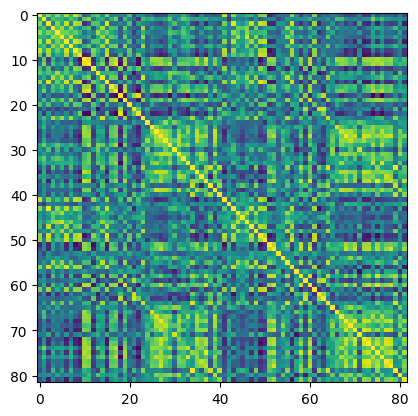

In [140]:
plt.imshow(dfc_awake[4000,:,:])

# [0,23] [24,41] [42,64] [65,82]

## DBSCAN clustering on Awake 

In [93]:
dfc_train_awake = dfc[id_sessions_awake_train,:,:].reshape(-1,82,82)
session = torch.from_numpy(dfc_train_awake).flatten(1)
corr = torch.corrcoef(session)
X = 1 - corr

For n_clusters = 13 The average silhouette_score is : 0.1215771372689578


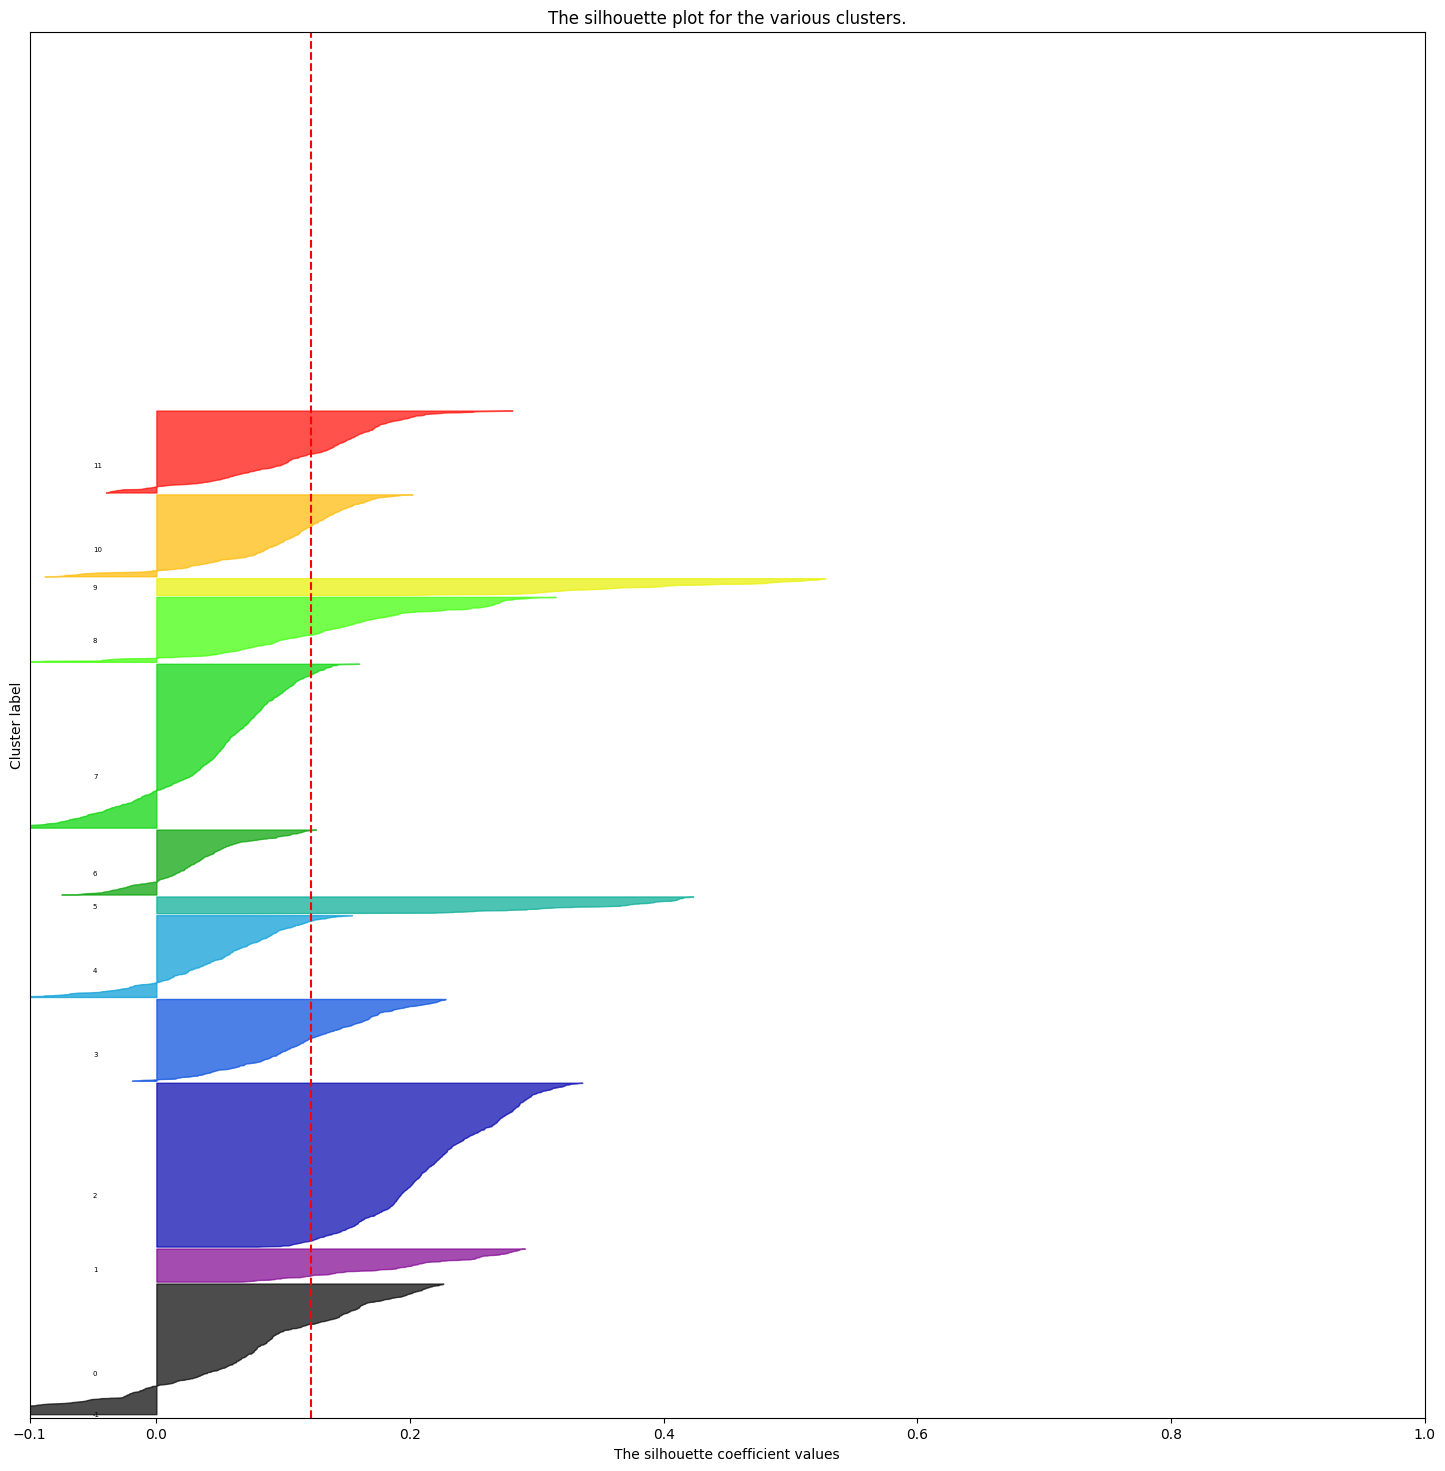

In [94]:
# Create a subplot with 1 row and 2 columns
fig, ax1 = plt.subplots(1, 1)
fig.set_size_inches(18, 18)

# Initialize the clusterer with n_clusters value and a random generator
# seed of 10 for reproducibility.
clustering = DBSCAN(eps=0.2, min_samples=10, metric="precomputed").fit(X)
#clustering = OPTICS(min_samples=5, min_cluster_size = 50, metric="precomputed").fit(X)
cluster_labels = clustering.labels_
n_clusters = len(np.unique(cluster_labels))

# The silhouette_score gives the average value for all the samples.
# This gives a perspective into the density and separation of the formed
# clusters
silhouette_avg = sklearn.metrics.silhouette_score(X, cluster_labels, metric = "precomputed")
print(
    "For n_clusters =",
    n_clusters,
    "The average silhouette_score is :",
    silhouette_avg,
)

# Compute the silhouette scores for each sample
sample_silhouette_values = sklearn.metrics.silhouette_samples(X, cluster_labels, metric = "precomputed")

# The 1st subplot is the silhouette plot
# The silhouette coefficient can range from -1, 1 but in this example all
# lie within [-0.1, 1]
ax1.set_xlim([-0.1, 1])
# The (n_clusters+1)*10 is for inserting blank space between silhouette
# plots of individual clusters, to demarcate them clearly.
ax1.set_ylim([0, 1.3*len(X)])

y_lower = 10
for i in range(-1,n_clusters-1):
    # Aggregate the silhouette scores for samples belonging to
    # cluster i, and sort them
    ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]

    ith_cluster_silhouette_values.sort()

    size_cluster_i = ith_cluster_silhouette_values.shape[0]
    y_upper = y_lower + size_cluster_i

    color = cm.nipy_spectral(float(i) / n_clusters)
    ax1.fill_betweenx(
        np.arange(y_lower, y_upper),
        0,
        ith_cluster_silhouette_values,
        facecolor=color,
        edgecolor=color,
        alpha=0.7,
    )

    # Label the silhouette plots with their cluster numbers at the middle
    ax1.text(-0.05, y_lower + 0.3 * size_cluster_i, str(i), fontsize=5)

    # Compute the new y_lower for next plot
    y_lower = y_upper + 10  # 10 for the 0 samples

ax1.set_title("The silhouette plot for the various clusters.")
ax1.set_xlabel("The silhouette coefficient values")
ax1.set_ylabel("Cluster label")

# The vertical line for average silhouette score of all the values
ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

ax1.set_yticks([])  # Clear the yaxis labels / ticks
ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

(array([ 922.,  922., 1802.,  461.,   97.,  364.,   42.,  461.,  461.,
         461.]),
 array([0. , 0.9, 1.8, 2.7, 3.6, 4.5, 5.4, 6.3, 7.2, 8.1, 9. ]),
 <BarContainer object of 10 artists>)

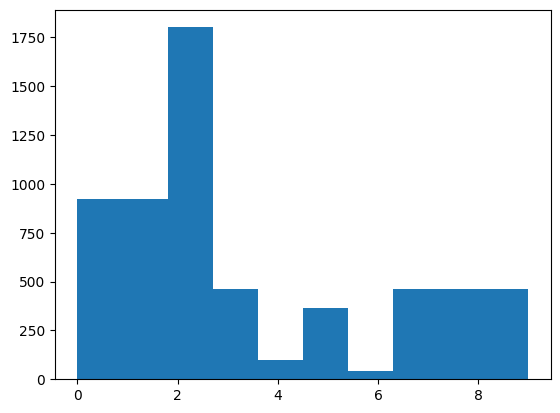

In [32]:
plt.hist(clustering.labels_,bins = len(np.unique(clustering.labels_)))

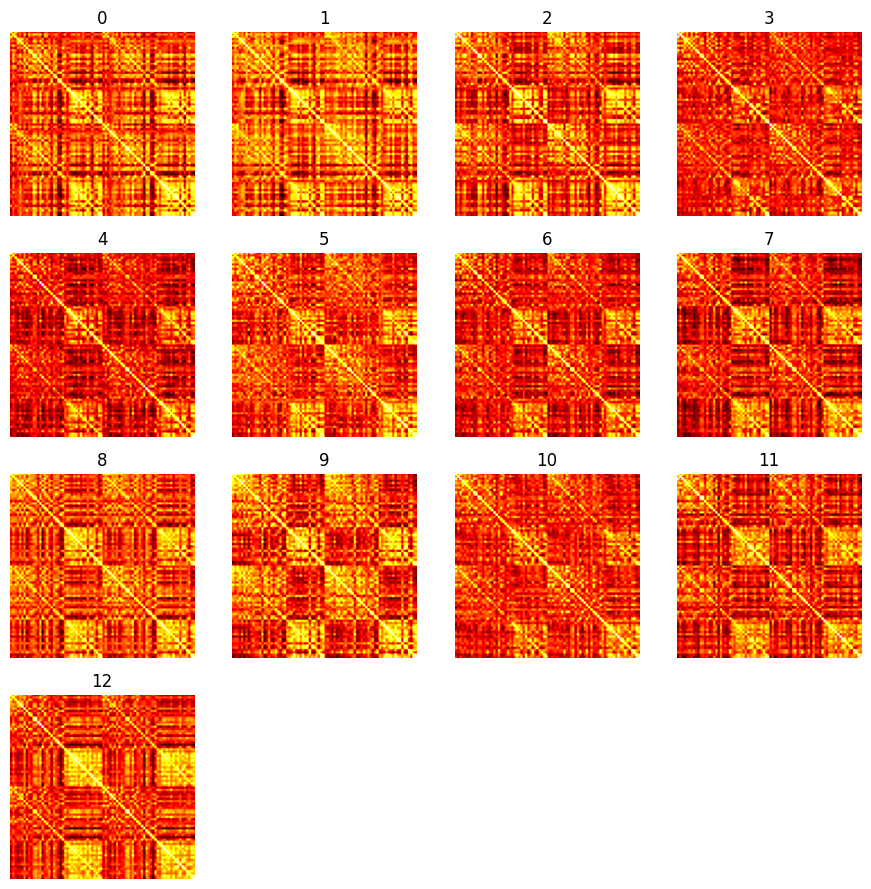

In [46]:
list_label = clustering.labels_
mean_states = np.array([np.mean(dfc_train_awake[list_label == i],axis=0) for i in np.unique(clustering.labels_)])
display(mean_states,np.unique(clustering.labels_))

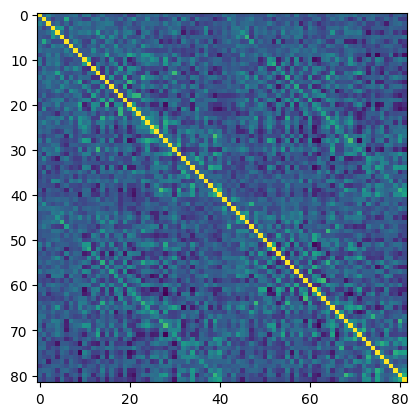

In [92]:
plt.imshow(mean_states[0])

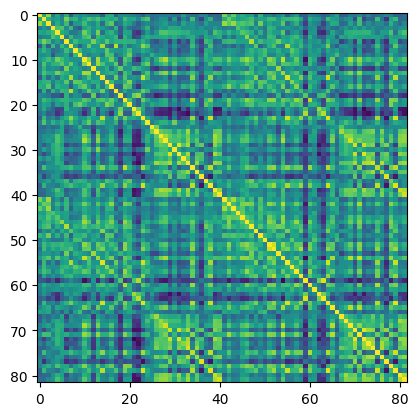

In [50]:
plt.imshow(mean_states[1])

## DBS clustering on light-propofol 

In [62]:
dfc_train_light_propofol = dfc[id_sessions_light_propofol_train,:,:].reshape(-1,82,82)
session = torch.from_numpy(dfc_train_light_propofol).flatten(1)
corr = torch.corrcoef(session)
X = 1 - corr

For n_clusters = 23 The average silhouette_score is : 0.09190834686661528


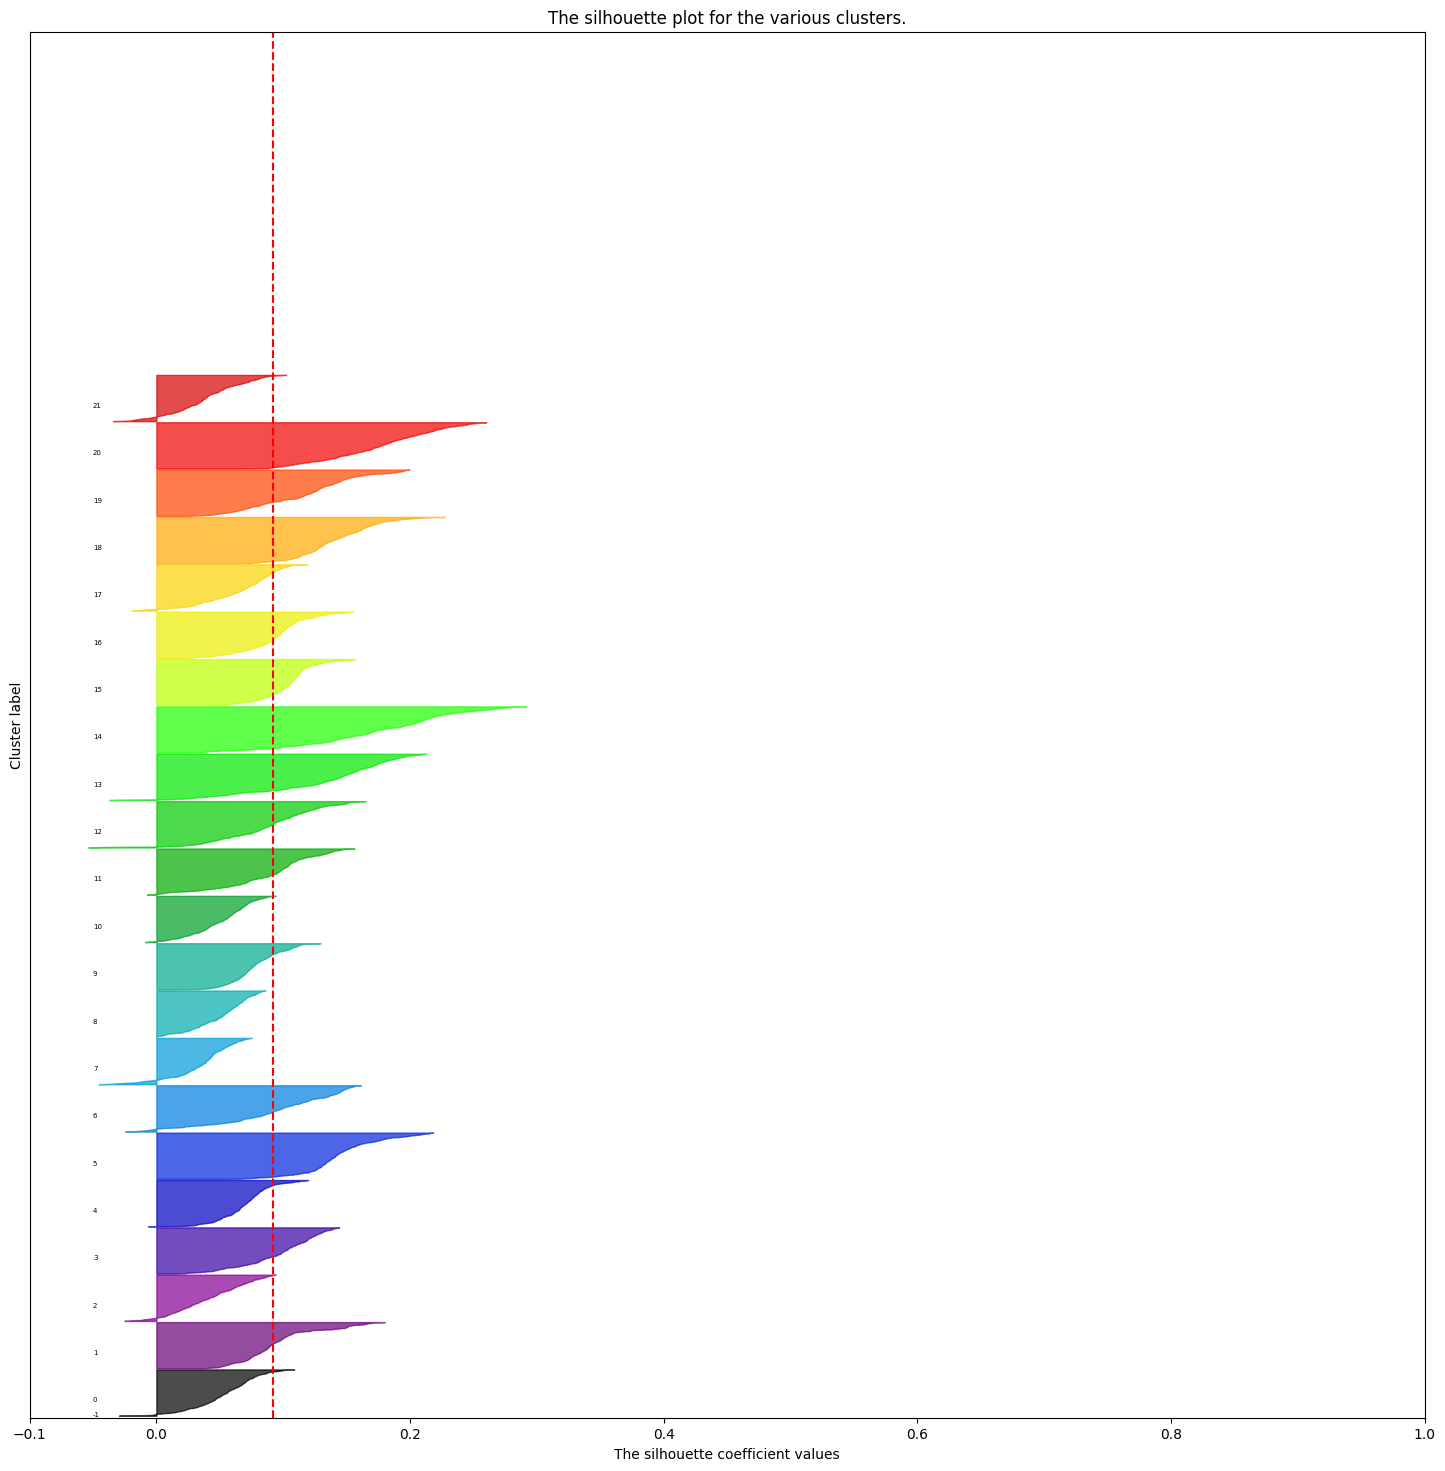

In [63]:
# Create a subplot with 1 row and 2 columns
fig, ax1 = plt.subplots(1, 1)
fig.set_size_inches(18, 18)

# Initialize the clusterer with n_clusters value and a random generator
# seed of 10 for reproducibility.
clustering = DBSCAN(eps=0.2, min_samples=10, metric="precomputed").fit(X)
#clustering = OPTICS(min_samples=5, min_cluster_size = 50, metric="precomputed").fit(X)
cluster_labels = clustering.labels_
n_clusters = len(np.unique(cluster_labels))

# The silhouette_score gives the average value for all the samples.
# This gives a perspective into the density and separation of the formed
# clusters
silhouette_avg = sklearn.metrics.silhouette_score(X, cluster_labels, metric = "precomputed")
print(
    "For n_clusters =",
    n_clusters,
    "The average silhouette_score is :",
    silhouette_avg,
)

# Compute the silhouette scores for each sample
sample_silhouette_values = sklearn.metrics.silhouette_samples(X, cluster_labels, metric = "precomputed")

# The 1st subplot is the silhouette plot
# The silhouette coefficient can range from -1, 1 but in this example all
# lie within [-0.1, 1]
ax1.set_xlim([-0.1, 1])
# The (n_clusters+1)*10 is for inserting blank space between silhouette
# plots of individual clusters, to demarcate them clearly.
ax1.set_ylim([0, 1.3*len(X)])

y_lower = 10
for i in range(-1,n_clusters-1):
    # Aggregate the silhouette scores for samples belonging to
    # cluster i, and sort them
    ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]

    ith_cluster_silhouette_values.sort()

    size_cluster_i = ith_cluster_silhouette_values.shape[0]
    y_upper = y_lower + size_cluster_i

    color = cm.nipy_spectral(float(i) / n_clusters)
    ax1.fill_betweenx(
        np.arange(y_lower, y_upper),
        0,
        ith_cluster_silhouette_values,
        facecolor=color,
        edgecolor=color,
        alpha=0.7,
    )

    # Label the silhouette plots with their cluster numbers at the middle
    ax1.text(-0.05, y_lower + 0.3 * size_cluster_i, str(i), fontsize=5)

    # Compute the new y_lower for next plot
    y_lower = y_upper + 10  # 10 for the 0 samples

ax1.set_title("The silhouette plot for the various clusters.")
ax1.set_xlabel("The silhouette coefficient values")
ax1.set_ylabel("Cluster label")

# The vertical line for average silhouette score of all the values
ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

ax1.set_yticks([])  # Clear the yaxis labels / ticks
ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

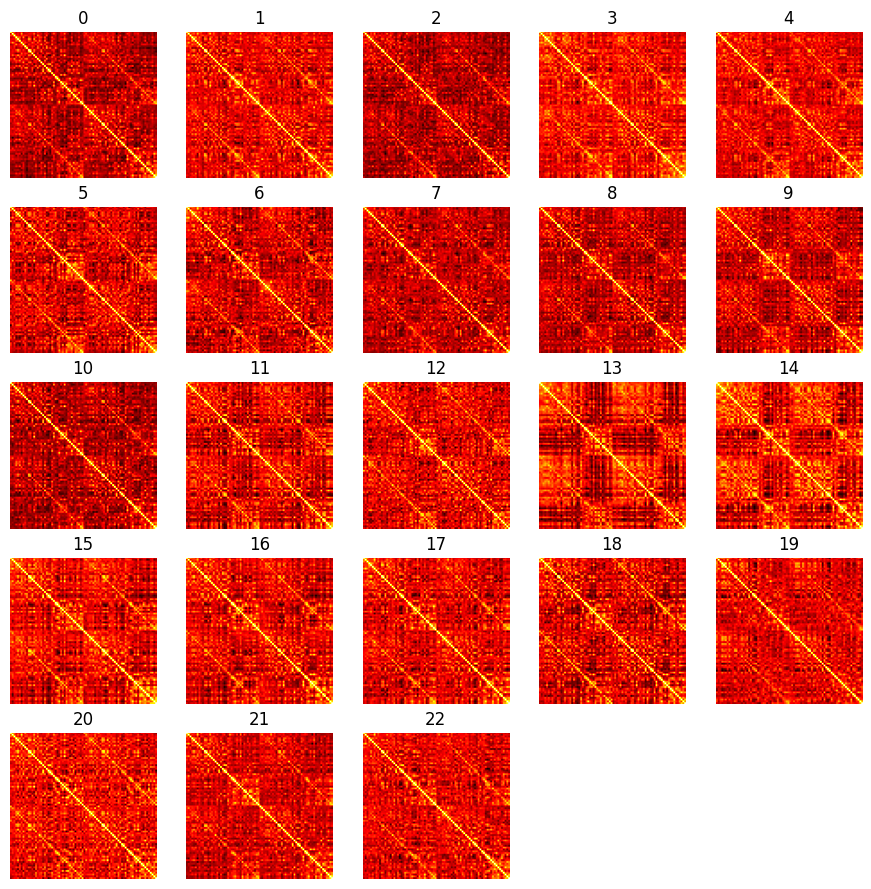

In [64]:
list_label = clustering.labels_
mean_states = np.array([np.mean(dfc_train_light_propofol[list_label == i],axis=0) for i in np.unique(clustering.labels_)])
display(mean_states,np.unique(clustering.labels_))

## DBScan clustering on deep-propofol

In [65]:
dfc_train_deep_propofol = dfc[id_sessions_deep_propofol_train,:,:].reshape(-1,82,82)
session = torch.from_numpy(dfc_train_deep_propofol).flatten(1)
corr = torch.corrcoef(session)
X = 1 - corr

For n_clusters = 22 The average silhouette_score is : 0.08911343407660759


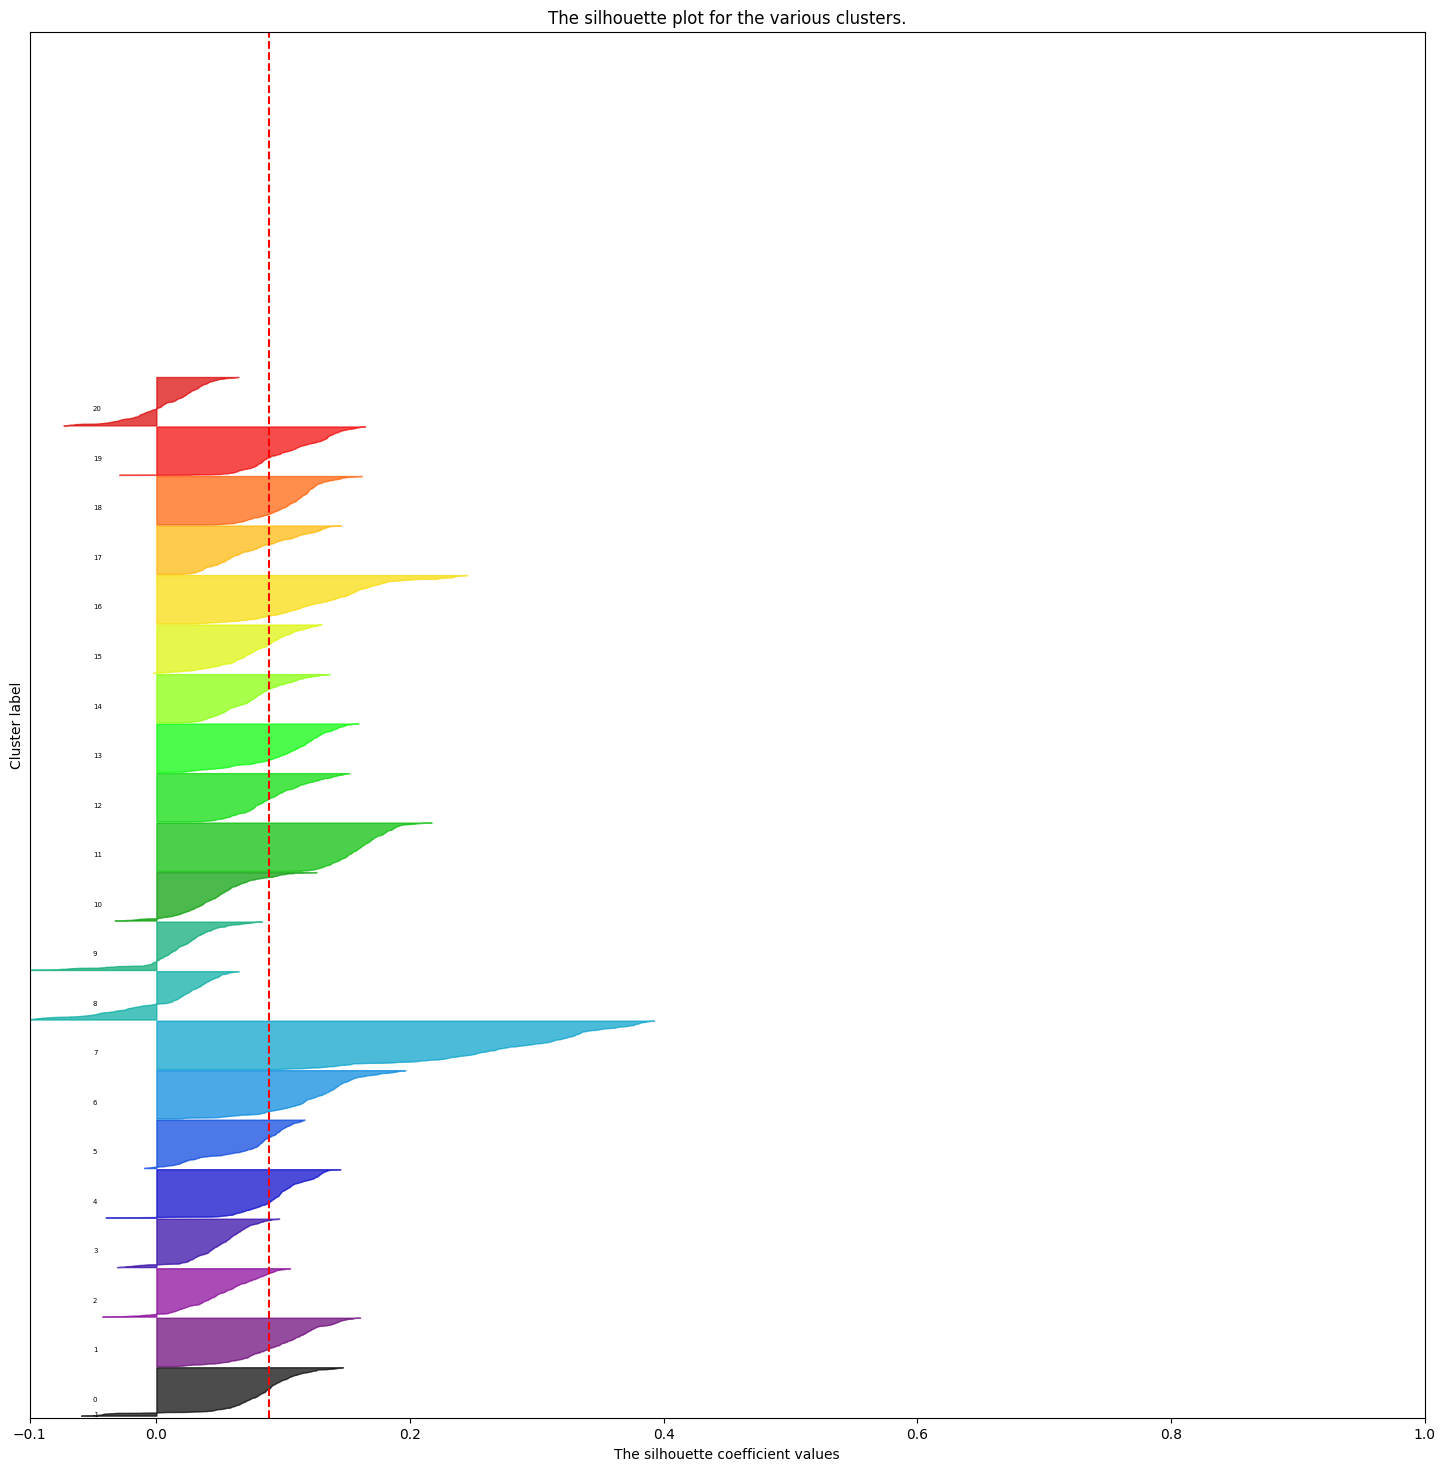

In [66]:
# Create a subplot with 1 row and 2 columns
fig, ax1 = plt.subplots(1, 1)
fig.set_size_inches(18, 18)

# Initialize the clusterer with n_clusters value and a random generator
# seed of 10 for reproducibility.
clustering = DBSCAN(eps=0.2, min_samples=10, metric="precomputed").fit(X)
#clustering = OPTICS(min_samples=5, min_cluster_size = 50, metric="precomputed").fit(X)
cluster_labels = clustering.labels_
n_clusters = len(np.unique(cluster_labels))

# The silhouette_score gives the average value for all the samples.
# This gives a perspective into the density and separation of the formed
# clusters
silhouette_avg = sklearn.metrics.silhouette_score(X, cluster_labels, metric = "precomputed")
print(
    "For n_clusters =",
    n_clusters,
    "The average silhouette_score is :",
    silhouette_avg,
)

# Compute the silhouette scores for each sample
sample_silhouette_values = sklearn.metrics.silhouette_samples(X, cluster_labels, metric = "precomputed")

# The 1st subplot is the silhouette plot
# The silhouette coefficient can range from -1, 1 but in this example all
# lie within [-0.1, 1]
ax1.set_xlim([-0.1, 1])
# The (n_clusters+1)*10 is for inserting blank space between silhouette
# plots of individual clusters, to demarcate them clearly.
ax1.set_ylim([0, 1.3*len(X)])

y_lower = 10
for i in range(-1,n_clusters-1):
    # Aggregate the silhouette scores for samples belonging to
    # cluster i, and sort them
    ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]

    ith_cluster_silhouette_values.sort()

    size_cluster_i = ith_cluster_silhouette_values.shape[0]
    y_upper = y_lower + size_cluster_i

    color = cm.nipy_spectral(float(i) / n_clusters)
    ax1.fill_betweenx(
        np.arange(y_lower, y_upper),
        0,
        ith_cluster_silhouette_values,
        facecolor=color,
        edgecolor=color,
        alpha=0.7,
    )

    # Label the silhouette plots with their cluster numbers at the middle
    ax1.text(-0.05, y_lower + 0.3 * size_cluster_i, str(i), fontsize=5)

    # Compute the new y_lower for next plot
    y_lower = y_upper + 10  # 10 for the 0 samples

ax1.set_title("The silhouette plot for the various clusters.")
ax1.set_xlabel("The silhouette coefficient values")
ax1.set_ylabel("Cluster label")

# The vertical line for average silhouette score of all the values
ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

ax1.set_yticks([])  # Clear the yaxis labels / ticks
ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

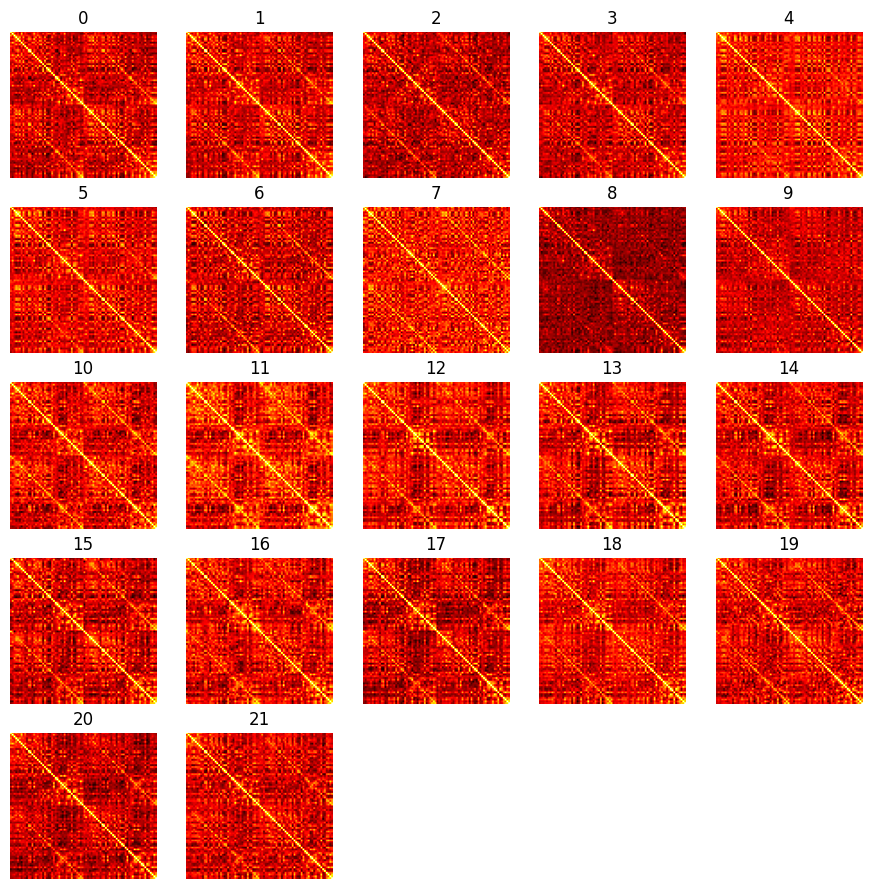

In [68]:
list_label = clustering.labels_
mean_states = np.array([np.mean(dfc_train_deep_propofol[list_label == i],axis=0) for i in np.unique(clustering.labels_)])
display(mean_states,np.unique(clustering.labels_))

## DBSCAN clustering for light-sevoflurane

In [88]:
dfc_train_light_sevoflurane = dfc[id_sessions_ketamine_train,:,:].reshape(-1,82,82)
session = torch.from_numpy(dfc_train_light_sevoflurane).flatten(1)
corr = torch.corrcoef(session)
X = 1 - corr

For n_clusters = 25 The average silhouette_score is : 0.14064968241837775


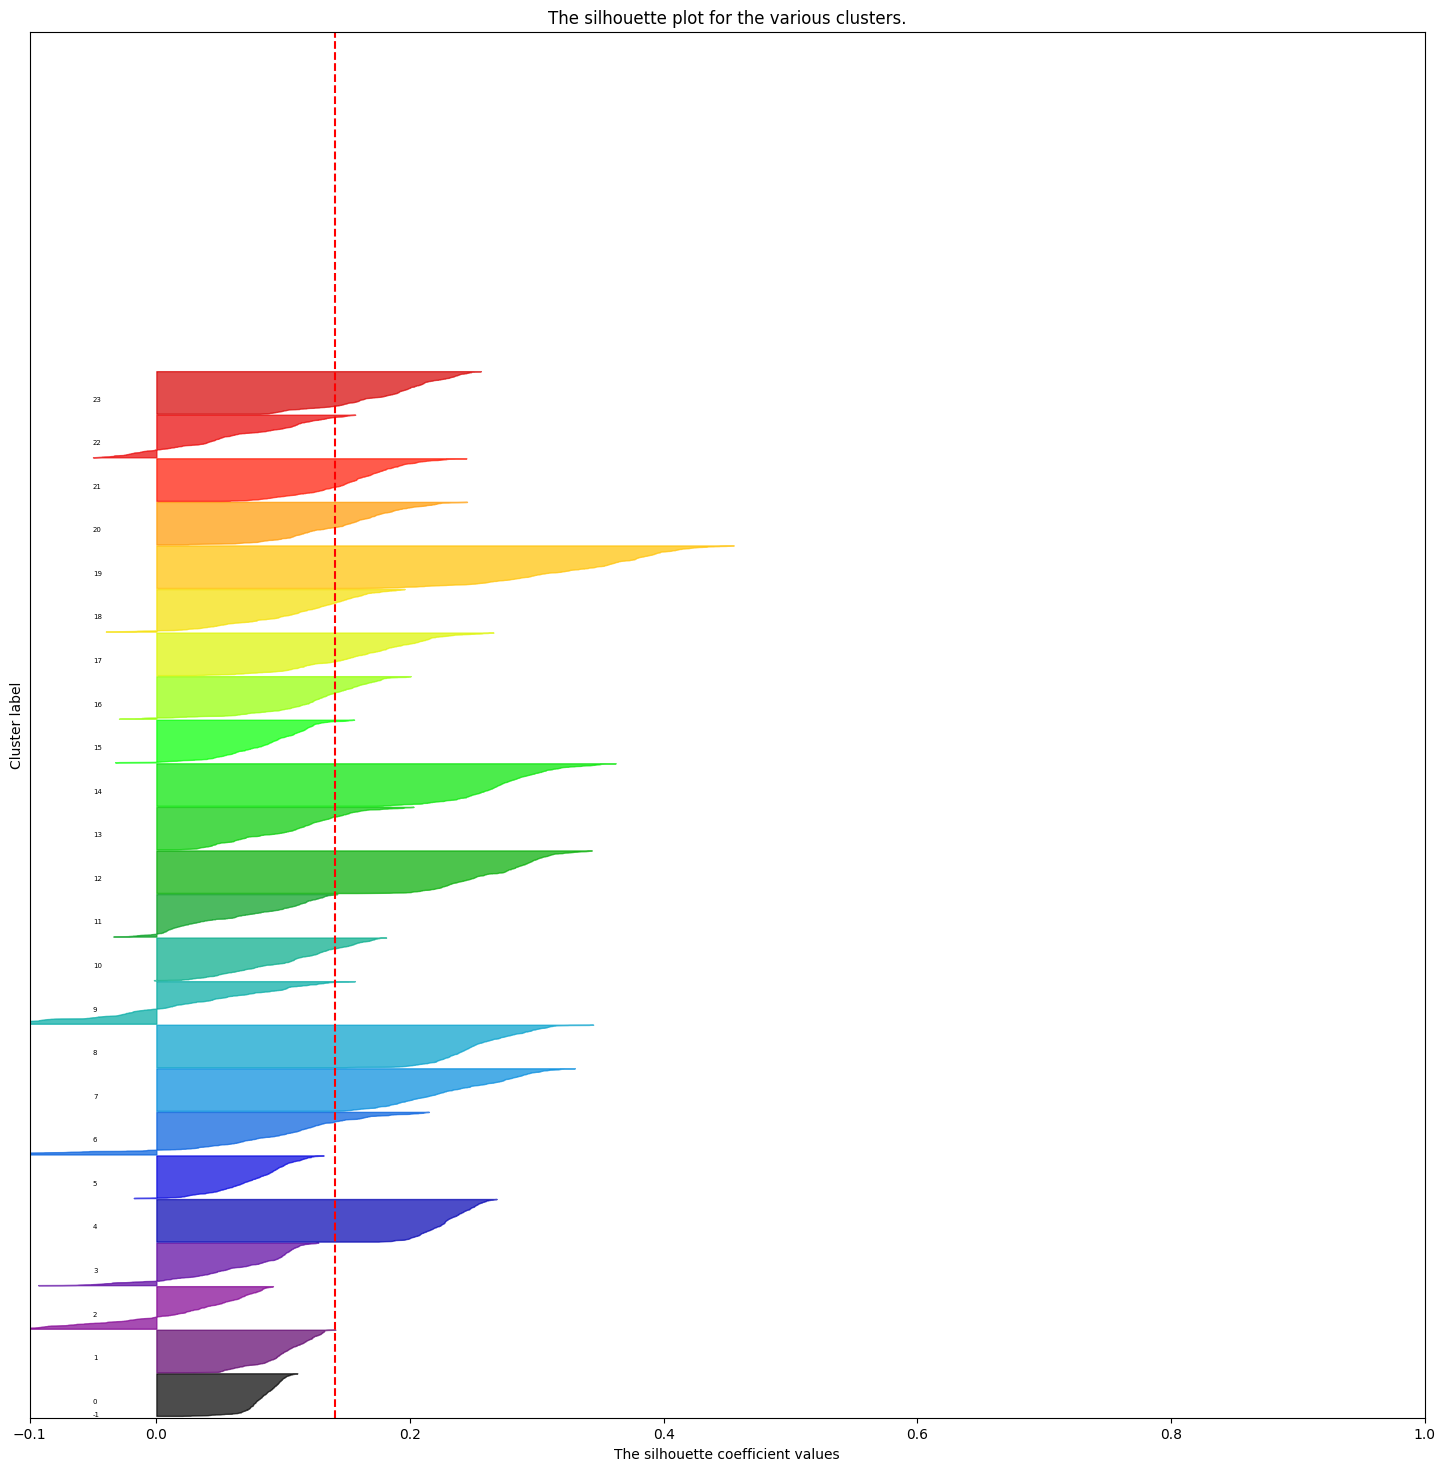

In [89]:
# Create a subplot with 1 row and 2 columns
fig, ax1 = plt.subplots(1, 1)
fig.set_size_inches(18, 18)

# Initialize the clusterer with n_clusters value and a random generator
# seed of 10 for reproducibility.
clustering = DBSCAN(eps=0.2, min_samples=10, metric="precomputed").fit(X)
#clustering = OPTICS(min_samples=5, min_cluster_size = 50, metric="precomputed").fit(X)
cluster_labels = clustering.labels_
n_clusters = len(np.unique(cluster_labels))

# The silhouette_score gives the average value for all the samples.
# This gives a perspective into the density and separation of the formed
# clusters
silhouette_avg = sklearn.metrics.silhouette_score(X, cluster_labels, metric = "precomputed")
print(
    "For n_clusters =",
    n_clusters,
    "The average silhouette_score is :",
    silhouette_avg,
)

# Compute the silhouette scores for each sample
sample_silhouette_values = sklearn.metrics.silhouette_samples(X, cluster_labels, metric = "precomputed")

# The 1st subplot is the silhouette plot
# The silhouette coefficient can range from -1, 1 but in this example all
# lie within [-0.1, 1]
ax1.set_xlim([-0.1, 1])
# The (n_clusters+1)*10 is for inserting blank space between silhouette
# plots of individual clusters, to demarcate them clearly.
ax1.set_ylim([0, 1.3*len(X)])

y_lower = 10
for i in range(-1,n_clusters-1):
    # Aggregate the silhouette scores for samples belonging to
    # cluster i, and sort them
    ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]

    ith_cluster_silhouette_values.sort()

    size_cluster_i = ith_cluster_silhouette_values.shape[0]
    y_upper = y_lower + size_cluster_i

    color = cm.nipy_spectral(float(i) / n_clusters)
    ax1.fill_betweenx(
        np.arange(y_lower, y_upper),
        0,
        ith_cluster_silhouette_values,
        facecolor=color,
        edgecolor=color,
        alpha=0.7,
    )

    # Label the silhouette plots with their cluster numbers at the middle
    ax1.text(-0.05, y_lower + 0.3 * size_cluster_i, str(i), fontsize=5)

    # Compute the new y_lower for next plot
    y_lower = y_upper + 10  # 10 for the 0 samples

ax1.set_title("The silhouette plot for the various clusters.")
ax1.set_xlabel("The silhouette coefficient values")
ax1.set_ylabel("Cluster label")

# The vertical line for average silhouette score of all the values
ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

ax1.set_yticks([])  # Clear the yaxis labels / ticks
ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

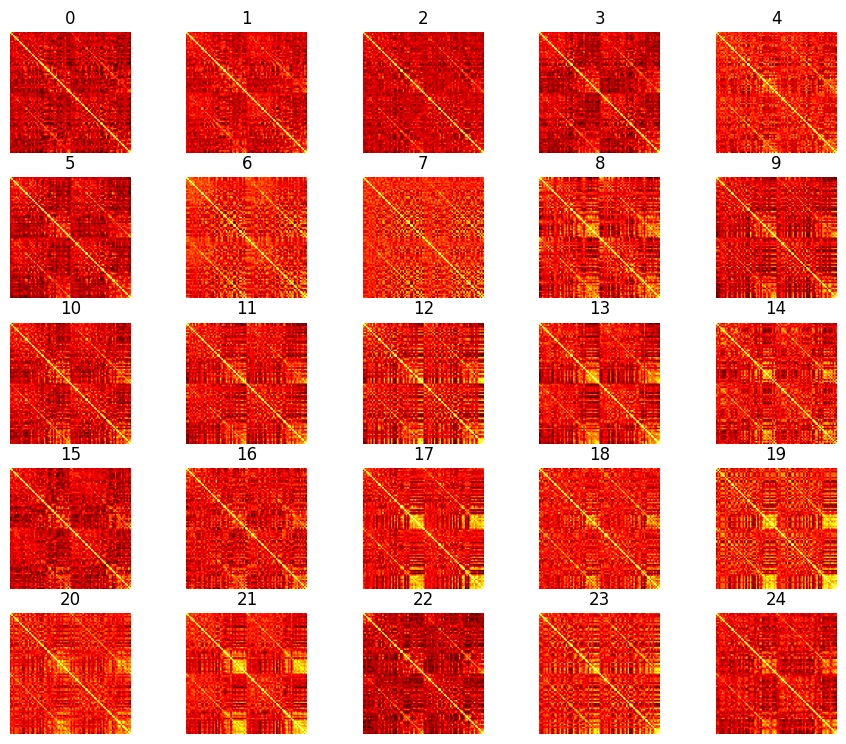

In [90]:
list_label = clustering.labels_
mean_states = np.array([np.mean(dfc_train_light_sevoflurane[list_label == i],axis=0) for i in np.unique(clustering.labels_)])
display(mean_states,np.unique(clustering.labels_))